# Using `libstempo` to for manipulating pulsar timing data and simulating mock data.

In this notebook you will learn:
* How to use `libstempo` to load `par` and `tim` files into a Python object for use in data analysis. 
* How to make a 

In this tutorial we will go through the basics of using `libstempo`, the `Python` wrapper for `tempo2`. After a brief introduction we will go on to using the `toasim` module to make mock data, adding various types of gravitational wave signals and noise sources. 

- **Install `miniconda` locally**

    `wget -q https://repo.continuum.io/miniconda/Miniconda2-latest-Linux-x86_64.sh`
    
    `bash Miniconda2-latest-Linux-x86_64.sh -b -p ~/.local/opt/miniconda2`
    
    `rm Miniconda2-latest-Linux-x86_64.sh`


- **Add miniconda’s `python`  to the front of your `$PATH`**

    `echo "export PATH=$HOME/.local/opt/miniconda2/bin:$PATH" >> .bashrc`
    
    `source .bashrc`


- **Install the basic python packages**

    `conda install -y numpy==1.13.3 cython scipy`


- **Install latest `libstempo` from GitHub with `pip`.  `tempo2` should be installed automatically.  Add extra ephemerides if needed**

    `pip install git+https://github.com/vallis/libstempo@master`
    
    use `--upgrade` if already installed.

## Load Modules

In [1]:
%matplotlib inline

from __future__ import division, print_function
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import sys,os,glob,json
from collections import OrderedDict

import libstempo as T2
import libstempo.toasim as LT
import libstempo.plot as LP

Enter the paths to the data files included with Steve Taylors `ipta_gwa_tutorial_part1.tar.gz`. These paths are written as if this notebook were placed in the same directory as the `ipta_gwa_tutorial.ipynb`. Please change them for your particular configuration, if necessary.

In [2]:
parpath = './partim_filtered_ppta_ng/'
timpath = './partim_filtered_ppta_ng/'
noisepath = './partim_filtered_ppta_ng/noisefiles_ppta_ng_normal/'

In [3]:
J1909_par = parpath + 'J1909-3744.par'
J1909_tim = timpath + 'J1909-3744.tim'

In [4]:
J1909 = T2.tempopulsar(parfile = J1909_par, timfile = J1909_tim, maxobs=30000, ephem='DE436',clk=None)

One can plot the residuals with the built-in plotting package. 

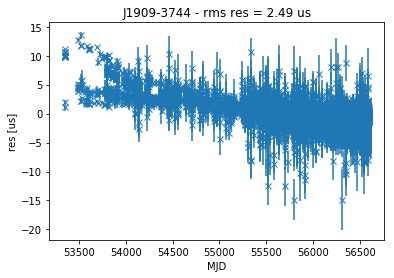

In [5]:
LP.plotres(J1909)

Or one can access the residual/TOAs/TOA errors directly and plot.

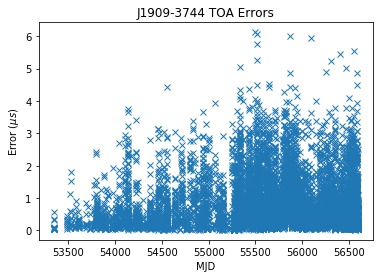

In [6]:
plt.plot(J1909.toas(),J1909.toaerrs,'x')
plt.title('{0} TOA Errors'.format(J1909.name))
plt.ylabel('Error ($\mu s$)')
plt.xlabel('MJD')
plt.show()

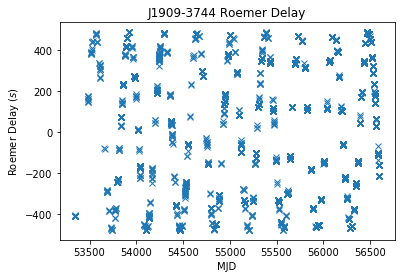

In [7]:
#Access the Roemer delays if concerned with the ephemeris
plt.plot(J1909.toas(),J1909.roemer,'x')
plt.title('{0} Roemer Delay'.format(J1909.name))
plt.ylabel('Roemer Delay ($s$)')
plt.xlabel('MJD')
plt.show()

In [8]:
#Which Clock file is used?
J1909.clock

'TT(BIPM2015)'

In [9]:
#Or the full list of parameters
J1909.pars()

('RAJ',
 'DECJ',
 'F0',
 'F1',
 'DM',
 'DM1',
 'DM2',
 'PMRA',
 'PMDEC',
 'PX',
 'SINI',
 'PB',
 'A1',
 'PBDOT',
 'XDOT',
 'TASC',
 'EPS1',
 'EPS2',
 'M2',
 'FD1',
 'JUMP5',
 'JUMP6',
 'JUMP7',
 'JUMP8',
 'JUMP9',
 'JUMP10',
 'JUMP11',
 'JUMP12',
 'JUMP13',
 'JUMP14',
 'JUMP15',
 'JUMP16',
 'JUMP17',
 'JUMP18',
 'JUMP19',
 'JUMP20',
 'JUMP21',
 'JUMP22',
 'JUMP23',
 'JUMP24')

For a full list of attributes one can type `J1909.` and hit the `tab` button (Note the period). Or use `J1909.__dir__()` for a full list of attributes. 

# Simulating Data with `libstempo.toasim`

One of the more useful modules in `libstempo` is `toasim`. There are a number of functions available for making fake pulsars. The command
```
fakepulsar(parfile, obstimes, toaerr, freq=1440.0, observatory='AXIS', flags='', iters=3)
``` 
has a long list of possible inputs. First we make a list of observing times.

In [10]:
t = np.arange(53000,56650,30.0) #observing dates for 10 years
t += np.random.randn(len(t)) #observe every 30+/-1 days

One can use a `par` file from a known pulsar.

In [11]:
J0613_par = parpath +'J0613-0200.par'
fake_J0613=LT.fakepulsar(J0613_par,obstimes=t,toaerr=0.5)

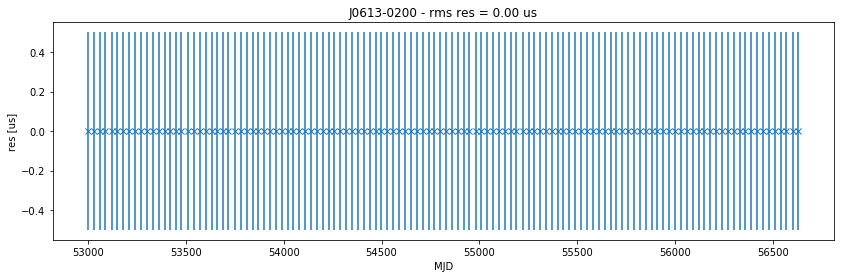

In [12]:
plt.figure(figsize=[14,4])
LP.plotres(fake_J0613)

This returns a version of J0613-0200 with no residuals and an even cadence. One can enter lists of TOA erros and observation times to make more realistic data. Of course the most unsettling characteristic of the data above is that there is no visible noise. One can add in noise with various other functions. Here we add in `EQUAD` and `EFAC`.

In [13]:
LT.add_equad(fake_J0613, equad=1e-7)
LT.add_efac(fake_J0613, efac=1.04)

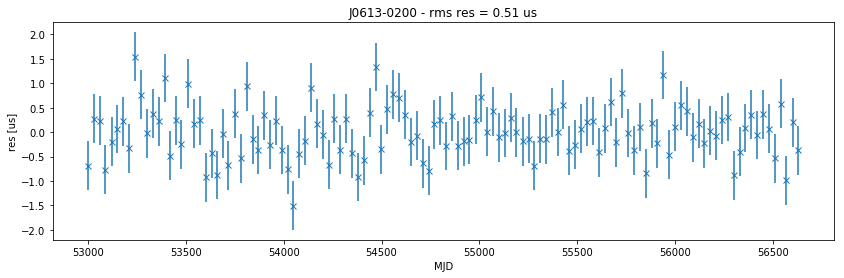

In [14]:
plt.figure(figsize=[14,4])
LP.plotres(fake_J0613)

One can add in powerlaw red noise as well. 

In [15]:
LT.add_rednoise(fake_J0613,A=1e-13,gamma=1)

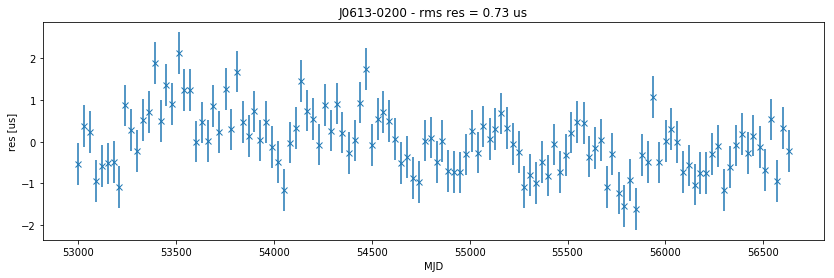

In [16]:
plt.figure(figsize=[14,4])
LP.plotres(fake_J0613)

Or use `add_dm` for chromatic red noise.

Of course one can add in a gravitational wave signal as well. 

In [17]:
#Add in a single continuous wave.
mass=5e9
fgw=1e-8
LT.add_cgw(fake_J0613, gwtheta=(12+43.0/60)*np.pi/180, gwphi=(12*15+27.0/60)*np.pi/180, 
           mc=mass, dist=15, fgw=fgw, phase0=0, psi=0, inc=0, pdist=1.0,
           pphase=None, psrTerm=True, evolve=True,
           phase_approx=False, tref=0)

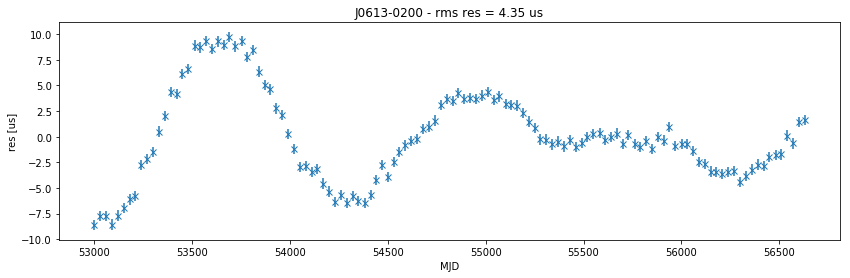

In [18]:
plt.figure(figsize=[14,4])
LP.plotres(fake_J0613)

In [19]:
# Save the new tim file
fake_J0613.savetim('./fake_j0613.tim')

This is, of course, a HUGE continuous wave signal, but useful for example purposes. The following command lists most of the functions for adding signals. 

In [20]:
additions = [att for att in LT.__dir__() if 'add' in att]
for ii in additions:
    print(ii)

add_cgw
add_dipole_gwb
add_glitch
add_ecc_cgw
add_equad
add_dm
add_rednoise
add_efac
add_gwb
add_jitter
add_line


We can also add a stochastic wave background using the `create_GWB` command. This uses correlations of the pulsars, rather than a sum of single sources. Therefore a full PTA of pulsars is needed. We will use the list of pulsars that comes with these tutorials as our PTA. Not only will we be using the `par` files from these IPTA pulsars, but we will also be using their noise parameters to simulate a IPTA-like dataset, that will have the same noise characteristics. 

In [21]:
psrlist=['J2317+1439',
 'J1857+0943',
 'J1909-3744',
 'J1741+1351',
 'J0030+0451',
 'J1614-2230',
 'J1012+5307',
 'J1853+1303',
 'J0613-0200',
 'J1024-0719',
 'J1600-3053',
 'J0437-4715',
 'J1640+2224',
 'J2010-1323',
 'J1455-3330',
 'J2145-0750',
 'J1918-0642',
 'J1713+0747',
 'J1744-1134']

In [22]:
parfiles = sorted(glob.glob(parpath+'*.par'))
timfiles = sorted(glob.glob(timpath+'*.tim'))
noisefiles = sorted(glob.glob(noisepath+'*.json'))

parfiles = [x for x in parfiles if x.split('/')[-1].split('.')[0] in psrlist]
timfiles = [x for x in timfiles if x.split('/')[-1].split('.')[0] in psrlist]
noisefiles = [x for x in noisefiles if x.split('/')[-1].split('_')[0] in psrlist]

print(len(parfiles),len(timfiles),len(noisefiles))

19 19 19


In [23]:
#######################################
# PASSING THROUGH TEMPO2 VIA libstempo
#######################################

t2psr = []
for ii in range(len(parfiles)):
    
    t2psr.append( T2.tempopulsar(parfile = parfiles[ii], timfile = timfiles[ii],
                                 maxobs=30000, ephem='DE436') )
    
    if np.any(np.isfinite(t2psr[ii].residuals())==False)==True:
        t2psr[ii] = T2.tempopulsar(parfile = parfiles[ii], timfile = timfiles[ii])
                 

    print('\r{0} of {1}'.format(ii+1,len(parfiles)),flush=True,end='')
    

19 of 19

Now we need to load in the noise files. The `json` files are written for use in `enterprise` and are normally read in as a large dicctionary. We will load them in the same way and then parse them for use in the various `add_`*noise*`()` methods of `toasim`.

In [24]:
noise_params = {}
for nf in noisefiles:
    p_name = nf.split('/')[-1].split('_')[0]
    with open(nf, 'r') as fin:
        noise_params.update(json.load(fin))

In [25]:
#Now parse this large dictionary so that we can call noise parameters as noise_dict[pulsar name][noise type]
#Returns either floats or 2 column arrays of flags and values. 

noise_dict = {}
for p in psrlist:
    noise_dict[p]={}
    noise_dict[p]['equads'] = []
    noise_dict[p]['efacs'] = []
    noise_dict[p]['ecorrs'] = []
    for ky in list(noise_params.keys()):
        if p in ky:
            if 'equad' in ky:
                noise_dict[p]['equads'].append([ky.replace(p + '_' , ''), noise_params[ky]])
            if 'efac' in ky:
                noise_dict[p]['efacs'].append([ky.replace(p + '_' , ''), noise_params[ky]])
            if 'ecorr' in ky:
                noise_dict[p]['ecorrs'].append([ky.replace(p + '_' , ''), noise_params[ky]])
            if 'gamma' in ky:
                noise_dict[p]['RN_gamma'] = noise_params[ky]
            if 'log10_A' in ky:
                noise_dict[p]['RN_Amp'] = 10**noise_params[ky]
                
    noise_dict[p]['equads'] = np.array(noise_dict[p]['equads'])
    noise_dict[p]['efacs'] = np.array(noise_dict[p]['efacs'])
    noise_dict[p]['ecorrs'] = np.array(noise_dict[p]['ecorrs'])    
    
    if len(noise_dict[p]['ecorrs'])==0: #Easier to just delete these dictionary items if no ECORR values. 
        noise_dict[p].__delitem__('ecorrs')

In [26]:
noise_dict['J2317+1439']['equads'][:,1]

array(['-6.549425170067322', '-6.684558819945579', '-6.398124559979138',
       '-6.40369344454936', '-6.399333516087468'], dtype='<U24')

In [27]:
#By using seeds we can  reproduce the dataset if need be. 
seed_efac = 1066
seed_equad = 1492
seed_jitter = 1776
seed_red = 1987
seed_gwb = 1667

Note: The `make_ideal` method sets the residuals of a given pulsar to zero. This is useful for then adding in any known signals you would like to simulate for an analysis. This will NOT effect your `tim` files unless you save them without changing the file path.

In [28]:
for ii,p in enumerate(t2psr):

    ## make ideal
    LT.make_ideal(p)

    ## add efacs
    LT.add_efac(p, efac = noise_dict[p.name]['efacs'][:,1], 
                flagid = 'f', flags = noise_dict[p.name]['efacs'][:,0], 
                seed = seed_efac + ii)

    ## add equads
    LT.add_equad(p, equad = noise_dict[p.name]['equads'][:,1], 
                 flagid = 'f', flags = noise_dict[p.name]['equads'][:,0], 
                 seed = seed_equad + ii)

    ## add jitter
    try: #Only NANOGrav Pulsars have ECORR
        LT.add_jitter(p, ecorr = noise_dict[p.name]['ecorrs'][:,1], 
                      flagid='f', flags = noise_dict[p.name]['ecorrs'][:,0], 
                      coarsegrain = 1.0/86400.0, seed=seed_jitter + ii)
    except KeyError:
        pass

    ## add red noise
    LT.add_rednoise(p, noise_dict[p.name]['RN_Amp'], noise_dict[p.name]['RN_gamma'], 
                    components = 30, seed = seed_red + ii)
    
    print(ii, p.name)

0 J0030+0451
1 J0437-4715
2 J0613-0200
3 J1012+5307
4 J1024-0719
5 J1455-3330
6 J1600-3053
7 J1614-2230
8 J1640+2224
9 J1713+0747
10 J1741+1351
11 J1744-1134
12 J1853+1303
13 J1857+0943
14 J1909-3744
15 J1918-0642
16 J2010-1323
17 J2145-0750
18 J2317+1439


Once we have a full PTA of pulsars with realistic noise injected we can then add in a gravitational wave background using pulsar spacial correlations. See the function docstring for details and references. 

In [29]:
# Create GWB
# Takes a list of libstempo pulsar objects as input.
LT.createGWB(t2psr, Amp=6.6e-15, gam=13./3., seed=seed_gwb)